In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

#Get the ISO-Codes
iso = pd.read_csv("../../Data/ISO/ISO.csv")

In [2]:
# --- : Load DataFrames from CSV ---
print("\nLoading W_ij Dataframes from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['../../Data/Networks/W_1_ij.csv', '../../Data/Networks/W_2_ij.csv', '../../Data/Networks/W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        base_name = os.path.basename(filename) # Gets 'W_1_ij.csv'
        parts = base_name.split('_') # Splits into ['W', '1', 'ij.csv']
        
        # Check if the parts list has at least 2 elements and the second part is a number
        if len(parts) >= 2 and parts[1].isdigit():
            df_number = parts[1]
            new_df_name = f"W_{df_number}_ij"
        else:
            # Fallback if filename format is unexpected, or use the full name as before
            new_df_name = os.path.splitext(base_name)[0] 
            
        W_ij_dataframes[new_df_name] = df_reloaded
        print(f"Loaded {filename} as {new_df_name}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij Dataframes from CSV files...
Loaded ../../Data/Networks/W_1_ij.csv as W_1_ij
Loaded ../../Data/Networks/W_2_ij.csv as W_2_ij
Loaded ../../Data/Networks/W_3_ij.csv as W_3_ij


In [3]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 81353, Filtered rows: 69127
Filtered W_2_ij. Original rows: 34585, Filtered rows: 29382
Filtered W_3_ij. Original rows: 94775, Filtered rows: 78649



Saving plot to ../../../Writing/Master/figures/outdegree_centrality_CHN_plot.png with 300 DPI...
Plot saved successfully!


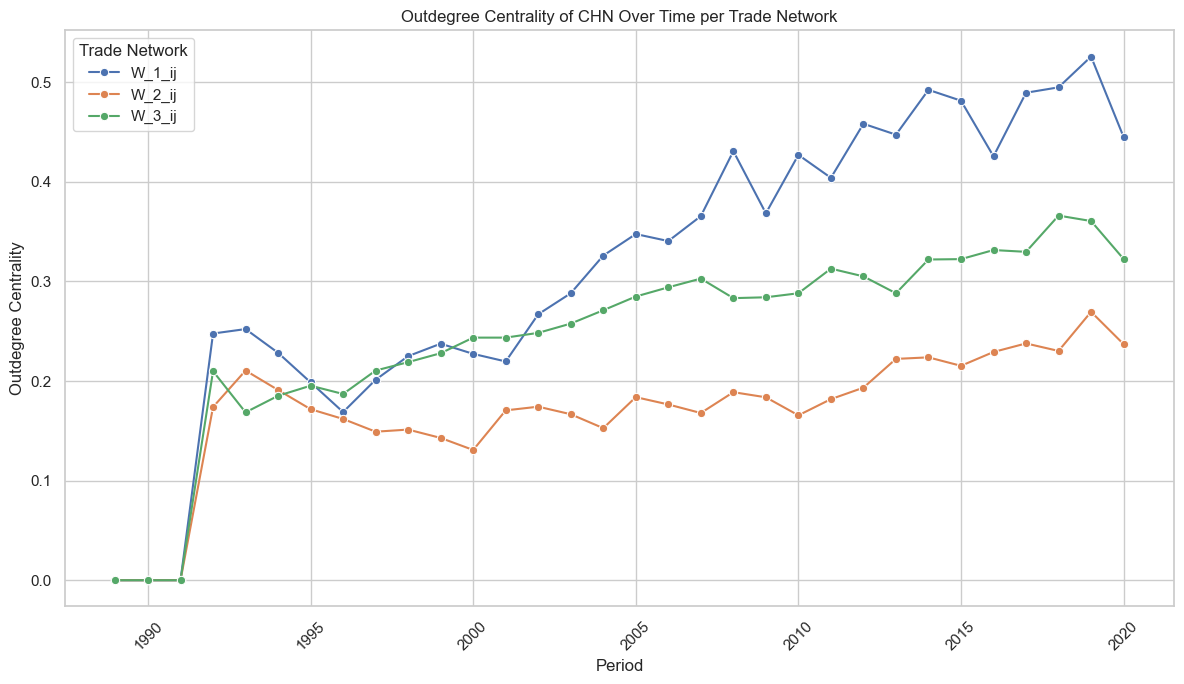

In [4]:
def calculate_outdegree_centrality_for_iso(df, iso_code):
    yearly_centrality = []
    if iso_code not in df['reporterISO'].unique() and iso_code not in df['partnerISO'].unique():
        return pd.DataFrame([{'period': year, 'outdegree_centrality': 0} for year in df['period'].unique()])
    
    for year, group in df.groupby('period'):
        G = nx.DiGraph()
        for _, row in group.iterrows():
            G.add_edge(row['reporterISO'], row['partnerISO'], weight=row['W_ij'])
        
        outdegree_centrality = nx.out_degree_centrality(G)
        
        centrality_value = outdegree_centrality.get(iso_code, 0)
        yearly_centrality.append({'period': year, 'outdegree_centrality': centrality_value})
    
    return pd.DataFrame(yearly_centrality)

df_centrality_W1 = calculate_outdegree_centrality_for_iso(W_ij_dataframes["W_1_ij"], 'CHN')
df_centrality_W1 = df_centrality_W1.rename(columns={'outdegree_centrality': 'W_1_ij'})

df_centrality_W2 = calculate_outdegree_centrality_for_iso(W_ij_dataframes["W_2_ij"], 'CHN')
df_centrality_W2 = df_centrality_W2.rename(columns={'outdegree_centrality': 'W_2_ij'})

df_centrality_W3 = calculate_outdegree_centrality_for_iso(W_ij_dataframes["W_3_ij"], 'CHN')
df_centrality_W3 = df_centrality_W3.rename(columns={'outdegree_centrality': 'W_3_ij'})

merged_df = pd.merge(df_centrality_W1, df_centrality_W2, on='period', how='outer').fillna(0)
merged_df = pd.merge(merged_df, df_centrality_W3, on='period', how='outer').fillna(0)

# Reshape the dataframe from wide to long format for Seaborn
long_format_df = pd.melt(merged_df, id_vars=['period'], var_name='DataFrame', value_name='outdegree_centrality')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=long_format_df,
    x='period',
    y='outdegree_centrality',
    hue='DataFrame',
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('Outdegree Centrality')
plt.title('Outdegree Centrality of CHN Over Time per Trade Network')
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

output_filename = '../../../Writing/Master/figures/outdegree_centrality_CHN_plot.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except Exception as e:
    print(f"Error saving plot: {e}")


Saving plot to ../../../Writing/Master/figures/indegree_centrality_CHN_plot.png with 300 DPI...
Plot saved successfully!


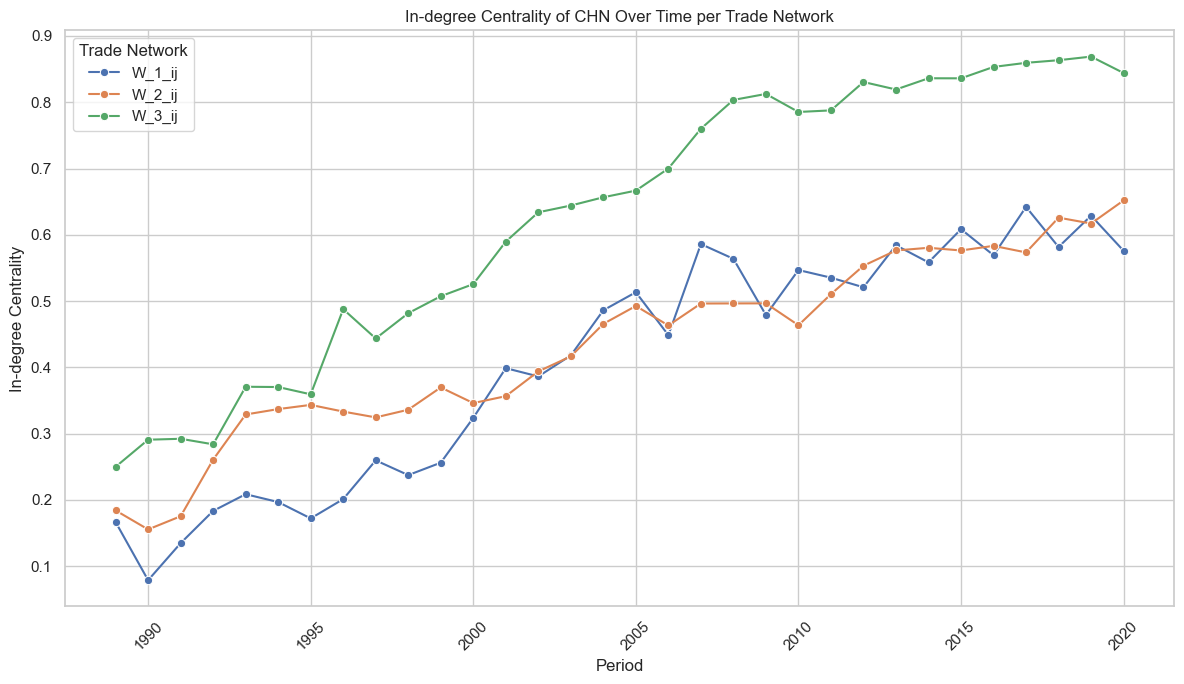

In [5]:
def calculate_indegree_centrality_for_iso(df, iso_code):
    yearly_centrality = []
    if iso_code not in df['reporterISO'].unique() and iso_code not in df['partnerISO'].unique():
        return pd.DataFrame([{'period': year, 'indegree_centrality': 0} for year in df['period'].unique()])
    
    for year, group in df.groupby('period'):
        G = nx.DiGraph()
        for _, row in group.iterrows():
            G.add_edge(row['reporterISO'], row['partnerISO'], weight=row['W_ij'])
        
        indegree_centrality = nx.in_degree_centrality(G)
        
        centrality_value = indegree_centrality.get(iso_code, 0)
        yearly_centrality.append({'period': year, 'indegree_centrality': centrality_value})
    
    return pd.DataFrame(yearly_centrality)

df_centrality_W1 = calculate_indegree_centrality_for_iso(W_ij_dataframes["W_1_ij"], 'CHN')
df_centrality_W1 = df_centrality_W1.rename(columns={'indegree_centrality': 'W_1_ij'})

df_centrality_W2 = calculate_indegree_centrality_for_iso(W_ij_dataframes["W_2_ij"], 'CHN')
df_centrality_W2 = df_centrality_W2.rename(columns={'indegree_centrality': 'W_2_ij'})

df_centrality_W3 = calculate_indegree_centrality_for_iso(W_ij_dataframes["W_3_ij"], 'CHN')
df_centrality_W3 = df_centrality_W3.rename(columns={'indegree_centrality': 'W_3_ij'})

merged_df = pd.merge(df_centrality_W1, df_centrality_W2, on='period', how='outer').fillna(0)
merged_df = pd.merge(merged_df, df_centrality_W3, on='period', how='outer').fillna(0)

# Reshape the dataframe from wide to long format for Seaborn
long_format_df = pd.melt(merged_df, id_vars=['period'], var_name='DataFrame', value_name='indegree_centrality')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=long_format_df,
    x='period',
    y='indegree_centrality',
    hue='DataFrame',
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('In-degree Centrality')
plt.title('In-degree Centrality of CHN Over Time per Trade Network')
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

output_filename = '../../../Writing/Master/figures/indegree_centrality_CHN_plot.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except Exception as e:
    print(f"Error saving plot: {e}")


Saving plot to ../../../Writing/Master/figures/degree_centrality_CHN_plot.png with 300 DPI...
Plot saved successfully!


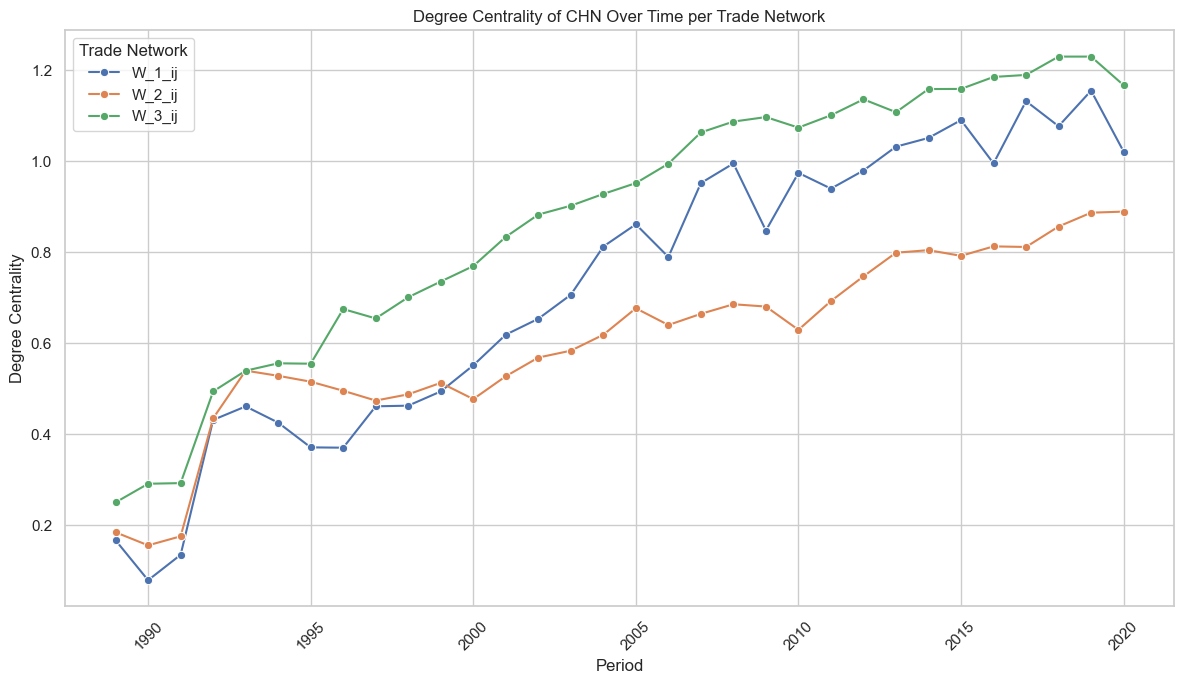

In [6]:
def calculate_degree_centrality_for_iso(df, iso_code):
    yearly_centrality = []
    if iso_code not in df['reporterISO'].unique() and iso_code not in df['partnerISO'].unique():
        return pd.DataFrame([{'period': year, 'degree_centrality': 0} for year in df['period'].unique()])
    
    for year, group in df.groupby('period'):
        G = nx.DiGraph()
        for _, row in group.iterrows():
            G.add_edge(row['reporterISO'], row['partnerISO'], weight=row['W_ij'])
        
        degree_centrality = nx.degree_centrality(G)
        
        centrality_value = degree_centrality.get(iso_code, 0)
        yearly_centrality.append({'period': year, 'degree_centrality': centrality_value})
    
    return pd.DataFrame(yearly_centrality)

df_centrality_W1 = calculate_degree_centrality_for_iso(W_ij_dataframes["W_1_ij"], 'CHN')
df_centrality_W1 = df_centrality_W1.rename(columns={'degree_centrality': 'W_1_ij'})

df_centrality_W2 = calculate_degree_centrality_for_iso(W_ij_dataframes["W_2_ij"], 'CHN')
df_centrality_W2 = df_centrality_W2.rename(columns={'degree_centrality': 'W_2_ij'})

df_centrality_W3 = calculate_degree_centrality_for_iso(W_ij_dataframes["W_3_ij"], 'CHN')
df_centrality_W3 = df_centrality_W3.rename(columns={'degree_centrality': 'W_3_ij'})

merged_df = pd.merge(df_centrality_W1, df_centrality_W2, on='period', how='outer').fillna(0)
merged_df = pd.merge(merged_df, df_centrality_W3, on='period', how='outer').fillna(0)

# Reshape the dataframe from wide to long format for Seaborn
long_format_df = pd.melt(merged_df, id_vars=['period'], var_name='DataFrame', value_name='degree_centrality')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=long_format_df,
    x='period',
    y='degree_centrality',
    hue='DataFrame',
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality of CHN Over Time per Trade Network')
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

output_filename = '../../../Writing/Master/figures/degree_centrality_CHN_plot.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except Exception as e:
    print(f"Error saving plot: {e}")